<a href="https://colab.research.google.com/github/benedikt-korbach/remote-sensing-of-parking-areas/blob/main/03_segment_parking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

This script contains the code to run the different models (U-Net, LinkNet, FPN), to perform hyper-parameter tuning and to evaluate model performance. It uses the [segmentation models](https://github.com/qubvel/segmentation_models?tab=readme-ov-file#license) library and adjust its [example code](https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb) to the problem of detecting car, truck and pull-of zones. The image/mask folders (except for the test cases) and models are not hosted on GitHub due to their large file size.


Input:

- training mask/image tiles (512x512, 256x256, 128x128)
- validation mask/image tiles (512x512, 256x256, 128x128)
- full-scale test cases (2560x2560)

# Import packages, mount drive, set wd

In [2]:
 %pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [3]:
import os
os.environ['SM_FRAMEWORK'] = "tf.keras"
from segmentation_models import Unet
from segmentation_models.metrics import IOUScore
from segmentation_models.losses import CategoricalFocalLoss
import segmentation_models as sm
import tensorflow as tf
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import matplotlib.pyplot as plt
import numpy as np
import datetime
import random
import shutil
import albumentations as A
import keras

Segmentation Models: using `tf.keras` framework.


In [4]:
# Mount GoogleDrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set wd
os.chdir("/content/drive/MyDrive/Master Thesis")
print("Working directory:", os.getcwd())

Working directory: /content/drive/MyDrive/Master Thesis


# Define Dataloader

In [6]:
# Helper function to adjust class values based on mask intensities
def adjust_mask(mask, class_values):
    # Create a blank array with zeros
    adjusted_mask = np.zeros((*mask.shape, len(class_values) + 1), dtype=np.float32) # +1 for background # asterix unpacks shape tuple

    for i, value in enumerate(class_values):
        adjusted_mask[:, :, i] = (mask == value) # Sets slice to 1 if mask has class value
    # Last channel for background
    adjusted_mask[:, :, -1] = (mask == 0) # background pixels
    return adjusted_mask

class Dataset(keras.utils.Sequence):
    """Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): Path to images folder.
        masks_dir (str): Path to segmentation masks folder.
        class_values (list): Pixel values to extract from the segmentation mask.
        augmentation (callable): Data transformation pipeline (e.g., flip, scale).
        preprocessing (callable): Data preprocessing (e.g., normalization, shape manipulation).
    """

    def __init__(self, images_dir, masks_dir, class_values=[100, 200, 255], augmentation=None, preprocessing=None):
        self.ids = [os.path.splitext(file)[0] for file in os.listdir(images_dir) if not file.startswith('.')] # list of base file names
        self.images_fps = [os.path.join(images_dir, id_ + ".png") for id_ in self.ids]
        self.masks_fps = [os.path.join(masks_dir, id_ + ".png") for id_ in self.ids]
        self.class_values = class_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i): # enables indexing of instances
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

        # Adjust the mask based on class values
        mask = adjust_mask(mask, self.class_values)

        # Apply augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # Apply preprocessing
        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=mask)
            image, mask = preprocessed["image"], preprocessed["mask"]

        return image, mask

    def __len__(self): # enables len()
        return len(self.ids)

class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches.

    Args:
        dataset: Instance of Dataset class for image loading and preprocessing.
        batch_size: Integer number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        # Collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        batch = [self.dataset[j] for j in range(start, stop)]

        # Transpose list of lists
        batch_images, batch_masks = zip(*batch)
        return np.stack(batch_images, axis=0), np.stack(batch_masks, axis=0) # returns single arrays for images and masks

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [7]:
# define augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5)
    ]
    return A.Compose(train_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

# Load and inspect training and validation set

## Load training and validation set

In [8]:
train_dataset = Dataset(
    images_dir="03_image_segmentation/train_validate_images_masks_reduced/train/images",
    masks_dir="03_image_segmentation/train_validate_images_masks_reduced/train/masks",
    class_values=[100, 200, 250], # Sets values to pixel intensities within masks (100 for cars, 200 for trucks, 250 for pull-off zones)
    augmentation=None,
    preprocessing=None
)

train_dataloader = Dataloader(dataset=train_dataset, batch_size=16, shuffle=True)

val_dataset = Dataset(
    images_dir="03_image_segmentation/train_validate_images_masks_reduced/val/images",
    masks_dir="03_image_segmentation/train_validate_images_masks_reduced/val/masks",
    class_values=[100, 200, 250],
    augmentation=None,
    preprocessing=None
)

val_dataloader = Dataloader(dataset=val_dataset, batch_size=1, shuffle=False)

## Inspect batches, images and masks

In [9]:
print("Number of batches: ", len(train_dataloader))
print("Elements within first batch", len(train_dataloader[0])) # image, mask

first_batch_images, _ = train_dataloader[0]
first_image = first_batch_images[0]
image_shape = first_image.shape
print("Image shape:", image_shape)

_, first_batch_masks = train_dataloader[0]
first_mask = first_batch_masks[0]
mask_shape = first_mask.shape
print("Mask shape:", mask_shape)

Number of batches:  80
Elements within first batch 2
Image shape: (512, 512, 3)
Mask shape: (512, 512, 4)


# Model Training 512x512

## U-Net

In [ ]:
# Define a function to create and train the model
def train_model(backbone, batch_size, encoder_freeze, epochs=50):

    # Define directories
    NAME = f"03_image_segmentation/models/unet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}" # Set model diretory
    print(NAME)
    HISTORY_DIR = "03_image_segmentation/models_training_history" # Set history diretory
    LR = 0.0001
    os.makedirs(NAME, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

    preprocess_input = sm.get_preprocessing(backbone) # Pre-process according to backbone

    # Set up model, optimizer, evaluation metrics and compile the model
    model = Unet(backbone, classes=4, activation="softmax", encoder_weights="imagenet", encoder_freeze=encoder_freeze)
    optim = keras.optimizers.Adam(LR)
    metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[0, 1], per_image=True), sm.metrics.FScore(threshold=0.5, class_indexes=[0, 1], per_image=True)] # Set [0,1] to calcualte mIoU over cars and trucks; [0] for cars; [1] for trucks
    model.compile(optimizer=optim, loss=sm.losses.dice_loss, metrics=metrics)

    # Define training and validation set
    train_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced/train/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced/train/masks",
        class_values=[100, 200, 250], # Class values correspond to pixel values in masks: 100 for cars, 200 for trucks, 250 for pull-off zones
        augmentation=get_training_augmentation(), # Augment training data with random flips/ rotations
        preprocessing=get_preprocessing(preprocess_input), # Pre-process according to chosen backbone
    )

    val_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced/val/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced/val/masks",
        class_values=[100, 200, 250],
        augmentation=None, # No augmentations for validation data
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(NAME, "best_model.h5"), monitor="val_loss", verbose=1, save_best_only=True, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    ]

    # Fit model
    history = model.fit(
        train_dataloader,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_dataloader
    )

    # Plot and save training history
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history.history["iou_score"])
    plt.plot(history.history["val_iou_score"])
    plt.title("Intersection over Union score")
    plt.ylabel("iou_score")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Dice loss")
    plt.ylabel("dice_loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.savefig(os.path.join(HISTORY_DIR, f"history_unet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}.png"), bbox_inches='tight')
    plt.close()

In [ ]:
# Define possible hyperparameters
backbones = ["resnet101", "vgg16"]
batch_sizes = [4, 8]
encoder_freezes = [True, False]

In [ ]:
# Loop over all combinations of hyperparameters
for backbone in backbones:
    for batch_size in batch_sizes:
        for encoder_freeze in encoder_freezes:
            start_time = datetime.datetime.now()
            print(f"Training model with Backbone: {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}")
            print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

            train_model(backbone, batch_size, encoder_freeze)

            end_time = datetime.datetime.now()
            print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Training Duration: {end_time - start_time}")

Training model with Backbone: resnet101, Batch Size: 4, Encoder Freeze: True
Start Time: 2024-04-14 08:28:30
03 Model Training/models/unet_resnet101_bs4_lr0.0001_e50_efTrue
171164896/171164896 [==============================] - 0s 0us/step
Epoch 1/50
320/320 [==============================] - ETA: 0s - loss: 0.7353 - iou_score: 0.2301 - f1-score: 0.2604
Epoch 1: val_loss improved from inf to 0.72407, saving model to 03 Model Training/models/unet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - 990s 3s/step - loss: 0.7353 - iou_score: 0.2301 - f1-score: 0.2604 - val_loss: 0.7241 - val_iou_score: 0.5829 - val_f1-score: 0.6161 - lr: 1.0000e-04
Epoch 2/50
320/320 [==============================] - ETA: 0s - loss: 0.6103 - iou_score: 0.4229 - f1-score: 0.4586
Epoch 2: val_loss improved from 0.72407 to 0.68770, saving model to 03 Model Training/models/unet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5
320/320 [==============================] - 62s 194ms/step - loss: 0.6103 - iou_score: 0.4229 - f1-score: 0.4586 - val_loss: 0.6877 - val_iou_score: 0.5833 - val_f1-score: 0.6211 - lr: 1.0000e-04
Epoch 3/50
320/320 [==============================] - ETA: 0s - loss: 0.5690 - iou_score: 0.4515 - f1-score: 0.4869
Epoch 3: val_loss improved from 0.68770 to 0.67268, saving model to 03 Model Training/models/unet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5
320/320 [==============================] - 61s 189ms/step - loss: 0.5690 - iou_score: 0.

## FPN

In [ ]:
# Define a function to create and train the model
def train_model(backbone, batch_size, encoder_freeze, epochs=50):

    # Define directories
    NAME = f"03_image_segmentation/models/fpn_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}"
    print(NAME)
    HISTORY_DIR = "03_image_segmentation/models_training_history"
    LR = 0.0001
    os.makedirs(NAME, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

    preprocess_input = sm.get_preprocessing(backbone)

    # Set up model, optimizer, evaluation metrics and compile the model
    model = sm.FPN(backbone, classes=4, activation="softmax", encoder_weights="imagenet", encoder_freeze=encoder_freeze)
    optim = keras.optimizers.Adam(LR)
    metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[0, 1], per_image=True), sm.metrics.FScore(threshold=0.5, class_indexes=[0, 1], per_image=True)]
    model.compile(optimizer=optim, loss=sm.losses.dice_loss, metrics=metrics)

    # Define training and validation set
    train_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced/train/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced/train/masks",
        class_values=[100, 200, 250],
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    val_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced/val/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced/val/masks",
        class_values=[100, 200, 250],
        augmentation=None,
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(NAME, "best_model.h5"), monitor="val_loss", verbose=1, save_best_only=True, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    ]

    # Fit model
    history = model.fit(
        train_dataloader,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_dataloader
    )

    # Plot and save training history
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history.history["iou_score"])
    plt.plot(history.history["val_iou_score"])
    plt.title("Intersection over Union")
    plt.ylabel("iou_score")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Dice Loss")
    plt.ylabel("dice_loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.savefig(os.path.join(HISTORY_DIR, f"history_fpn_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}.png"), bbox_inches='tight')
    plt.close()

In [ ]:
# Define possible hyperparameters
backbones = ["resnet101", "vgg"]
batch_sizes = [4,8]
encoder_freezes = [True, False]

In [ ]:
# Loop over all combinations of hyperparameters
for backbone in backbones:
    for batch_size in batch_sizes:
        for encoder_freeze in encoder_freezes:
            start_time = datetime.datetime.now()
            print(f"Training model with Backbone: {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}")
            print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

            train_model(backbone, batch_size, encoder_freeze)

            end_time = datetime.datetime.now()
            print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Training Duration: {end_time - start_time}")

## LinkNet

In [ ]:
# Define a function to create and train the model
def train_model(backbone, batch_size, encoder_freeze, epochs=50):

    # Define directories
    NAME = f"03_image_segmentation/models/linknet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}"
    print(NAME)
    HISTORY_DIR = "03_image_segmentation/models_training_history"
    LR = 0.0001
    os.makedirs(NAME, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

    preprocess_input = sm.get_preprocessing(backbone)

    # Set up model, optimizer, evaluation metrics and compile the model
    model = sm.Linknet(backbone, classes=4, activation="softmax", encoder_weights="imagenet", encoder_freeze=encoder_freeze)
    optim = keras.optimizers.Adam(LR)
    metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[0, 1], per_image=True), sm.metrics.FScore(threshold=0.5, class_indexes=[0, 1], per_image=True)]
    model.compile(optimizer=optim, loss=sm.losses.dice_loss, metrics=metrics)

    # Define training and validation set
    train_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced/train/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced/train/masks",
        class_values=[100, 200, 250],
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    val_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced/val/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced/val/masks",
        class_values=[100, 200, 250],
        augmentation=None,
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = Dataloader(val_dataset, batch_size=batch_size, shuffle=False)

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(NAME, "best_model.h5"), monitor="val_iou_score", verbose=1, save_best_only=True, mode="max"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    ]

    # Fit model
    history = model.fit(
        train_dataloader,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_dataloader
    )

    # Plot and save training history
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history.history["iou_score"])
    plt.plot(history.history["val_iou_score"])
    plt.title("Intersection over Union")
    plt.ylabel("iou_score")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Dice Loss")
    plt.ylabel("dice_loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.savefig(os.path.join(HISTORY_DIR, f"history_linknet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}.png"), bbox_inches='tight')
    plt.close()

In [ ]:
# Define possible hyperparameters
backbones = ["resnet101", "vgg16"]
batch_sizes = [4, 8]
encoder_freezes = [True, False]

In [ ]:
# Loop over all combinations of hyperparameters
for backbone in backbones:
    for batch_size in batch_sizes:
        for encoder_freeze in encoder_freezes:
            start_time = datetime.datetime.now()
            print(f"Training model with Backbone: {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}")
            print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

            train_model(backbone, batch_size, encoder_freeze)

            end_time = datetime.datetime.now()
            print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Training Duration: {end_time - start_time}")

Training model with Backbone: resnet101, Batch Size: 4, Encoder Freeze: True
Start Time: 2024-04-11 22:58:42
03 Model Training/models/linknet_resnet101_bs4_lr0.0001_e50_efTrue
Epoch 1/50
320/320 [==============================] - ETA: 0s - loss: 0.7334 - iou_score: 0.1935 - f1-score: 0.2212
Epoch 1: val_iou_score improved from -inf to 0.45135, saving model to 03 Model Training/models/linknet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5
320/320 [==============================] - 94s 182ms/step - loss: 0.7334 - iou_score: 0.1935 - f1-score: 0.2212 - val_loss: 0.6613 - val_iou_score: 0.4513 - val_f1-score: 0.4902 - lr: 1.0000e-04
Epoch 2/50
320/320 [==============================] - ETA: 0s - loss: 0.6308 - iou_score: 0.3690 - f1-score: 0.4041
Epoch 2: val_iou_score improved from 0.45135 to 0.47293, saving model to 03 Model Training/models/linknet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5
320/320 [==============================] - 59s 183ms/step - loss: 0.6308 - iou_score: 0.3690

## Model evaluation

### Model evaluation on validation set

In [13]:
# Define the hyperparameter combinations
model_types = ["unet", "fpn", "linknet"]
backbones = ["resnet101", "vgg16"]
batch_sizes = [4, 8,]
encoder_freezes = [True, False]

# Custom objects for loading models
custom_objects = {
    "iou_score": sm.metrics.IOUScore(threshold=0.5, class_indexes=[0,1], per_image=True), # Change class indices to only calculate mIoU for cars [0] or trucks [1]
    "f1-score": sm.metrics.FScore(threshold=0.5, class_indexes=[0,1], per_image=True), # Change class indices to only calculate f1 for cars [0] or trucks [1]
    "dice_loss": sm.losses.dice_loss
}

# Function to evaluate the model
def evaluate_model(model, dataloader):
    results = model.evaluate(dataloader, verbose=1)
    return results

# Store model performance for sorting
model_performance = []

# Loop over all combinations of model types and hyperparameters
for model_type in model_types:
    for backbone in backbones:
        for batch_size in batch_sizes:
            for encoder_freeze in encoder_freezes:
                model_dir = f"03_image_segmentation/models/{model_type}_{backbone}_bs{batch_size}_lr0.0001_e50_ef{str(encoder_freeze)}"
                model_path = os.path.join(model_dir, "best_model.h5")

                if os.path.exists(model_path):
                    print(f"Evaluating model {model_path}")
                    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

                    # Load validation dataset
                    val_dataset = Dataset(
                        images_dir="03_image_segmentation/train_validate_images_masks_reduced/val/images",
                        masks_dir="03_image_segmentation/train_validate_images_masks_reduced/val/masks",
                        class_values=[100, 200, 250],
                        augmentation=None,  # No augmentation for evaluation
                        preprocessing=get_preprocessing(sm.get_preprocessing(backbone))
                    )
                    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

                    # Evaluate the model
                    evaluation_results = evaluate_model(loaded_model, val_dataloader)
                    model_performance.append((model_path, evaluation_results[1]))
                    print(f"Results for {model_type} with {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}: {evaluation_results}")
                else:
                    print(f"Model file not found: {model_path}")

# Sort models by IoU score from highest to lowest
model_performance.sort(key=lambda x: x[1], reverse=True)

# Print sorted results
for model, iou_score in model_performance:
    print(f"Model {model} has IoU score: {iou_score}")


Evaluating model 03_image_segmentation/models/unet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5
327/327 [==============================] - 162s 480ms/step - loss: 0.6295 - iou_score: 0.7087 - f1-score: 0.7474
Results for unet with resnet101, Batch Size: 4, Encoder Freeze: True: [0.6294876933097839, 0.7086676955223083, 0.7474195957183838]
Evaluating model 03_image_segmentation/models/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5
327/327 [==============================] - 11s 27ms/step - loss: 0.6099 - iou_score: 0.7980 - f1-score: 0.8339
Results for unet with resnet101, Batch Size: 4, Encoder Freeze: False: [0.6098713278770447, 0.798020601272583, 0.8339118361473083]
Evaluating model 03_image_segmentation/models/unet_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5
327/327 [==============================] - 11s 28ms/step - loss: 0.6248 - iou_score: 0.7217 - f1-score: 0.7599
Results for unet with resnet101, Batch Size: 8, Encoder Freeze: True: [0.6247710585594177, 0.721739530563

Overall:

*   Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8193722367286682
*   Model 03_image_segmentation/models/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.809556653213501
*   Model 03_image_segmentation/models/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8012911677360535
*   Model 03_image_segmentation/models/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7995907664299011
*   Model 03_image_segmentation/models/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.798020601272583
*   Model 03_image_segmentation/models/fpn_vgg16_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7896596193313599
*   Model 03_image_segmentation/models/unet_vgg16_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7392765879631042
*   Model 03_image_segmentation/models/linknet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7337772250175476
*   Model 03_image_segmentation/models/unet_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7217395305633545
*   Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7141426801681519
*   Model 03_image_segmentation/models/unet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7086676955223083
*   Model 03_image_segmentation/models/fpn_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6982511878013611
*   Model 03_image_segmentation/models/fpn_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6978514790534973
*   Model 03_image_segmentation/models/fpn_vgg16_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6615665555000305
*   Model 03_image_segmentation/models/fpn_vgg16_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6480434536933899
*   Model 03_image_segmentation/models/unet_vgg16_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6446937918663025
*   Model 03_image_segmentation/models/unet_vgg16_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6436582803726196
*   Model 03_image_segmentation/models/linknet_vgg16_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6355123519897461
*   Model 03_image_segmentation/models/unet_vgg16_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.633143424987793
*   Model 03_image_segmentation/models/linknet_vgg16_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.5799106955528259
*   Model 03_image_segmentation/models/linknet_vgg16_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.3662072420120239
*   Model 03_image_segmentation/models/linknet_vgg16_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.3089069426059723
*   Model 03_image_segmentation/models/fpn_vgg16_bs8_lr0.0001_e50_efFalse/best_model.h5 stopped training and could not be evaluated
*   Model 03_image_segmentation/models/fpn_vgg16_bs8_lr0.0001_e50_efFalse/best_model.h5 stopped training and could not be evaluated


Car:

*   Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7656872868537903
*   Model 03_image_segmentation/models/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.763706624507904
*   Model 03_image_segmentation/models/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.761753261089325
*   Model 03_image_segmentation/models/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7593119144439697
*   Model 03_image_segmentation/models/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7523444890975952
*   Model 03_image_segmentationg/models/fpn_vgg16_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7369402647018433
*   Model 03_image_segmentation/models/unet_vgg16_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.716785728931427
*   Model 03_image_segmentation/models/linknet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7025055885314941
*   Model 03_image_segmentation/models/fpn_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6846007108688354
*   Model 03_image_segmentation/models/unet_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6842025518417358
*   Model 03_image_segmentation/models/linknet_vgg16_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6836614608764648
*   Model 03_image_segmentation/models/unet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6801961064338684
*   Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6799314618110657
*   Model 03_image_segmentation/models/unet_vgg16_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6484952569007874
*   Model 03_image_segmentation/models/fpn_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6390809416770935
*   Model 03_image_segmentation/models/fpn_vgg16_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6194937825202942
*   Model 03_image_segmentation/models/fpn_vgg16_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6100039482116699
*   Model 03_image_segmentation/models/linknet_vgg16_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.5954875946044922
*   Model 03_image_segmentation/models/linknet_vgg16_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.5810407996177673
*   Model 03_image_segmentation/models/unet_vgg16_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.5696407556533813
*   Model 03_image_segmentation/models/unet_vgg16_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.5260281562805176
*   Model 03_image_segmentation/models/linknet_vgg16_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.3559165894985199

Truck:

*   Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8730567693710327
*   Model 03_image_segmentation/models/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8604017496109009
*   Model 03_image_segmentation/models/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8502379059791565
*   Model 03_image_segmentation/models/fpn_vgg16_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8423789739608765
*   Model 03_image_segmentation/models/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8374282121658325
*   Model 03_image_segmentation/models/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8323343992233276
*   Model 03_image_segmentation/models/linknet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7650488018989563
*   Model 03_image_segmentation/models/unet_vgg16_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7617675065994263
*   Model 03_image_segmentation/models/unet_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7592764496803284
*   Model 03_image_segmentation/models/fpn_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7574213147163391
*   Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7483541965484619
*   Model 03_image_segmentation/models/unet_vgg16_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7402584552764893
*   Model 03_image_segmentation/models/unet_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7371395230293274
*   Model 03_image_segmentation/models/unet_vgg16_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7176753282546997
*   Model 03_image_segmentation/models/fpn_resnet101_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7111018896102905
*   Model 03_image_segmentation/models/fpn_vgg16_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.7036393880844116
*   Model 03_image_segmentation/models/fpn_vgg16_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.6860827207565308
*   Model 03_image_segmentation/models/unet_vgg16_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6408922672271729
*   Model 03_image_segmentation/models/linknet_vgg16_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.587363064289093
*   Model 03_image_segmentation/models/linknet_vgg16_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.564333975315094
*   Model 03_image_segmentation/models/linknet_vgg16_bs4_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.26189717650413513
*   Model 03_image_segmentation/models/linknet_vgg16_bs8_lr0.0001_e50_efTrue/best_model.h5 has IoU score: 0.1513737142086029

### Best model evaluation on test set

In [18]:
# Define the hyperparameter combinations
model_types = ["linknet"]
backbones = ["resnet101"]
batch_sizes = [8]
encoder_freezes = [False]

# Custom objects for loading models
custom_objects = {
    "iou_score": sm.metrics.IOUScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "f1-score": sm.metrics.FScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "dice_loss": sm.losses.dice_loss
}

# Function to evaluate the model
def evaluate_model(model, dataloader):
    results = model.evaluate(dataloader, verbose=1)
    return results

# Store model performance for sorting
model_performance = []

# Loop over all combinations of model types and hyperparameters
for model_type in model_types:
    for backbone in backbones:
        for batch_size in batch_sizes:
            for encoder_freeze in encoder_freezes:
                model_dir = f"03_image_segmentation/models/{model_type}_{backbone}_bs{batch_size}_lr0.0001_e50_ef{str(encoder_freeze)}"
                model_path = os.path.join(model_dir, "best_model.h5")

                if os.path.exists(model_path):
                    print(f"Evaluating model {model_path}")
                    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

                    # Load test dataset
                    test_dataset = Dataset(
                        images_dir="03_image_segmentation/test_images_masks/images_png",
                        masks_dir="03_image_segmentation/test_images_masks/masks",
                        class_values=[100, 200, 250],
                        augmentation=None,  # Usually, we don't apply augmentation to validation data
                        preprocessing=get_preprocessing(sm.get_preprocessing(backbone)),
                    )
                    test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

                    # Evaluate the model
                    evaluation_results = evaluate_model(loaded_model, test_dataloader)
                    model_performance.append((model_path, evaluation_results[1]))  # Assuming IoU is the second metric
                    print(f"Results for {model_type} with {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}: {evaluation_results}")
                else:
                    print(f"Model file not found: {model_path}")

# Sort models by IoU score from highest to lowest
model_performance.sort(key=lambda x: x[1], reverse=True)

# Print sorted results
for model, iou_score in model_performance:
    print(f"Model {model} has IoU score: {iou_score}")

Evaluating model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5
23/23 [==============================] - 16s 496ms/step - loss: 0.2831 - iou_score: 0.7010 - f1-score: 0.8125
Results for linknet with resnet101, Batch Size: 8, Encoder Freeze: False: [0.28312379121780396, 0.7010171413421631, 0.812473714351654]
Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7010171413421631


Overall:

Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7010171413421631

Car:

Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.59691321849823

Truck:

Model 03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8051210641860962



### Visual inspection of best model prediction on test cases

In [19]:
custom_objects = {
    "iou_score": sm.metrics.IOUScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "f1-score": sm.metrics.FScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "dice_loss": sm.losses.dice_loss
}

loaded_model = tf.keras.models.load_model(
    "03_image_segmentation/models/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5",
    custom_objects=custom_objects
)

BACKBONE = "resnet101"
preprocess_input = sm.get_preprocessing(BACKBONE)

Code used to [create contours](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html)

In [20]:
def predict_and_visualize_with_mask_edges(model, dataloader, batch_num=0, image_num=0, output_path=None, attribution_text_gt=None, attribution_text_pred=None):
    colors = {
        "car_parking": (0, 0, 255),  # cars in blue
        "truck_parking": (255, 0, 0),  # trucks in red
        "quick_parking": (0, 255, 0),  # quick parking in green
    }

    # Get specified batch
    if batch_num >= len(dataloader):
        print(f"Batch number {batch_num} is out of range. The dataloader has {len(dataloader)} batches.")
        return

    batch = dataloader[batch_num]
    images = batch[0]
    true_masks = batch[1]

    if image_num >= images.shape[0]:
        print(f"Image number {image_num} is out of range. The batch has {images.shape[0]} images.")
        return

    # Select the specified image and its true mask
    display_image = images[image_num]
    display_true_mask = np.argmax(true_masks[image_num], axis=-1) if true_masks.ndim == 4 else true_masks[image_num]

    # Prepare original image
    display_image_bgr = cv2.cvtColor(display_image, cv2.COLOR_RGB2BGR)

    # Predict mask for the selected image
    pred_mask = model.predict(np.expand_dims(display_image, axis=0))
    display_pred_mask = np.argmax(pred_mask[0], axis=-1) if pred_mask.ndim == 4 else pred_mask[0]

    # Draw contours for the true mask on a copy of the image
    true_mask_contoured = display_image_bgr.copy()
    for channel, color in enumerate(colors.values()):
        true_mask = display_true_mask == channel
        contours, _ = cv2.findContours(true_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(true_mask_contoured, contours, -1, color, 2)

    # Draw contours for the predicted mask on a copy of the image
    pred_mask_contoured = display_image_bgr.copy()
    for channel, color in enumerate(colors.values()):
        pred_mask = display_pred_mask == channel
        contours, _ = cv2.findContours(pred_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(pred_mask_contoured, contours, -1, color, 2)

    # Plot the images
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(true_mask_contoured, cv2.COLOR_BGR2RGB))
    plt.title("Ground Truth")
    plt.axis("off")
    if attribution_text_gt is not None:
        ax1.text(x=1, y=0, s=attribution_text_gt, horizontalalignment="right", verticalalignment="bottom",
                 transform=ax1.transAxes, color="white", fontsize=7, bbox=dict(facecolor="black", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.1"))

    ax2 = plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(pred_mask_contoured, cv2.COLOR_BGR2RGB))
    plt.title("Prediction")
    plt.axis("off")
    if attribution_text_pred is not None:
        ax2.text(x=1, y=0, s=attribution_text_pred, horizontalalignment="right", verticalalignment="bottom",
                 transform=ax2.transAxes, color="white", fontsize=7, bbox=dict(facecolor="black", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.1"))

    # Save the figure if an output path is provided
    if output_path is not None:
        plt.savefig(output_path, bbox_inches="tight", pad_inches=0, dpi=100)

    plt.show()


In [21]:
# Load test dataset

test_dataset = Dataset(
    images_dir="03_image_segmentation/test_images_masks/images_png",
    masks_dir="03_image_segmentation/test_images_masks/masks",
    class_values=[100, 200, 250],
    augmentation=None,
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

In [22]:
# Inspect test data set batches and dimensions

print("Number of batches: ", len(test_dataloader))
print("Elements within first batch:", len(test_dataloader[0])) # image, mask

first_batch_images, _ = test_dataloader[0]
first_image = first_batch_images[0]
image_shape = first_image.shape
print("Image shape:", image_shape)

_, first_batch_masks = test_dataloader[0]
first_mask = first_batch_masks[0]
mask_shape = first_image.shape
print("Mask shape:", mask_shape)

Number of batches:  23
Elements within first batch: 2
Image shape: (2560, 2560, 3)
Mask shape: (2560, 2560, 3)


1/1 [==============================] - 2s 2s/step


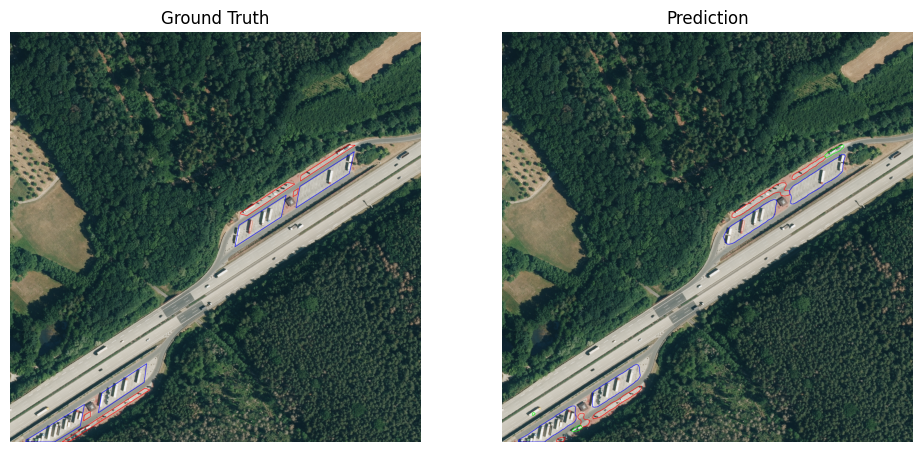

In [23]:
predict_and_visualize_with_mask_edges(loaded_model, test_dataloader, batch_num=0, image_num=0, output_path=None, attribution_text_gt=None, attribution_text_pred=None)

Selected images for download:

- 3: lon_10.9544554_lat_50.9407623_Erfurter Becken - Ost: Thuringia
- 7: lon_10.1726923_lat_51.0086765_Burgberg: Hessia
- lon_9.6807029_lat_52.8134767_Wolfsgrund West: Lower Saxony


# Model Training 256x256

In [24]:
train_dataset = Dataset(
    images_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/train/images",
    masks_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/train/masks",
    class_values=[100, 200, 250],
    augmentation=None,
    preprocessing=None
)

train_dataloader = Dataloader(dataset=train_dataset, batch_size=1, shuffle=True)

val_dataset = Dataset(
    images_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/images",
    masks_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/masks",
    class_values=[100, 200, 250],
    augmentation=None,
    preprocessing=None
)

val_dataloader = Dataloader(dataset=val_dataset, batch_size=1, shuffle=False)

In [25]:
print("Number of batches: ", len(train_dataloader))
print("Elements within first batch", len(train_dataloader[0])) # image, mask

first_batch_images, _ = train_dataloader[0]
first_image = first_batch_images[0]
image_shape = first_image.shape
print("Image shape:", image_shape)

_, first_batch_masks = train_dataloader[0]
first_mask = first_batch_masks[0]
mask_shape = first_mask.shape
print("Mask shape:", mask_shape)

Number of batches:  2877
Elements within first batch 2
Image shape: (256, 256, 3)
Mask shape: (256, 256, 4)


## U-Net

In [15]:
# Define a function to create and train the model
def train_model(backbone, batch_size, encoder_freeze, epochs=50):

    # Define directories
    NAME = f"03_image_segmentation/models_256/unet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}"
    print(NAME)
    HISTORY_DIR = "03_image_segmentation/models_training_history_256"
    LR = 0.0001
    os.makedirs(NAME, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

    preprocess_input = sm.get_preprocessing(backbone)

    # Set up model, optimizer, evaluation metrics and compile the model
    model = Unet(backbone, classes=4, activation="softmax", encoder_weights="imagenet", encoder_freeze=encoder_freeze)
    optim = keras.optimizers.Adam(LR)
    metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[0, 1], per_image=True), sm.metrics.FScore(threshold=0.5, class_indexes=[0, 1], per_image=True)]
    model.compile(optimizer=optim, loss=sm.losses.dice_loss, metrics=metrics)

    # Define training and validation set
    train_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/train/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/train/masks",
        class_values=[100, 200, 250],
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    val_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/masks",
        class_values=[100, 200, 250],
        augmentation=None,
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(NAME, "best_model.h5"), monitor="val_loss", verbose=1, save_best_only=True, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    ]

    # Fit model
    history = model.fit(
        train_dataloader,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_dataloader
    )

    # Plot and save training history
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history.history["iou_score"])
    plt.plot(history.history["val_iou_score"])
    plt.title("Intersection over Union score")
    plt.ylabel("iou_score")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Dice loss")
    plt.ylabel("dice_loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.savefig(os.path.join(HISTORY_DIR, f"history_unet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}.png"), bbox_inches='tight')
    plt.close()

In [16]:
# Define possible hyperparameters
backbones = ["resnet101"]
batch_sizes = [4, 8, 16, 32, 64]
encoder_freezes = [False]

In [17]:
# Loop over all combinations of hyperparameters
for backbone in backbones:
    for batch_size in batch_sizes:
        for encoder_freeze in encoder_freezes:
            start_time = datetime.datetime.now()
            print(f"Training model with Backbone: {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}")
            print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

            train_model(backbone, batch_size, encoder_freeze)

            end_time = datetime.datetime.now()
            print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Training Duration: {end_time - start_time}")

Training model with Backbone: resnet101, Batch Size: 4, Encoder Freeze: False
Start Time: 2024-04-22 15:10:19
03 Model Training/models_256/unet_resnet101_bs4_lr0.0001_e50_efFalse
Epoch 1/50
719/719 [==============================] - ETA: 0s - loss: 0.7029 - iou_score: 0.4131 - f1-score: 0.4390
Epoch 1: val_loss improved from inf to 0.76710, saving model to 03 Model Training/models_256/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


719/719 [==============================] - 2400s 3s/step - loss: 0.7029 - iou_score: 0.4131 - f1-score: 0.4390 - val_loss: 0.7671 - val_iou_score: 0.5812 - val_f1-score: 0.5994 - lr: 1.0000e-04
Epoch 2/50
719/719 [==============================] - ETA: 0s - loss: 0.6241 - iou_score: 0.4576 - f1-score: 0.4848
Epoch 2: val_loss improved from 0.76710 to 0.71135, saving model to 03 Model Training/models_256/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5
719/719 [==============================] - 79s 110ms/step - loss: 0.6241 - iou_score: 0.4576 - f1-score: 0.4848 - val_loss: 0.7113 - val_iou_score: 0.6805 - val_f1-score: 0.7058 - lr: 1.0000e-04
Epoch 3/50
719/719 [==============================] - ETA: 0s - loss: 0.6044 - iou_score: 0.5020 - f1-score: 0.5285
Epoch 3: val_loss did not improve from 0.71135
719/719 [==============================] - 72s 97ms/step - loss: 0.6044 - iou_score: 0.5020 - f1-score: 0.5285 - val_loss: 0.7396 - val_iou_score: 0.5388 - val_f1-score: 0.5563 - lr

ResourceExhaustedError: Graph execution error:

Detected at node model_11/decoder_stage0_concat/concat-0-TransposeNHWCToNCHW-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[64,2048,16,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_11/decoder_stage0_concat/concat-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1494916]

## LinkNet

In [10]:
# Define a function to create and train the model
def train_model(backbone, batch_size, encoder_freeze, epochs=50):

    # Define directories
    NAME = f"03_image_segmentation/models_256/linknet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}"
    print(NAME)
    HISTORY_DIR = "03_image_segmentation/models_training_history_256"
    LR = 0.0001
    os.makedirs(NAME, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

    preprocess_input = sm.get_preprocessing(backbone)

    # Set up model, optimizer, evaluation metrics and compile the model
    model = sm.Linknet(backbone, classes=4, activation="softmax", encoder_weights="imagenet", encoder_freeze=encoder_freeze)
    optim = keras.optimizers.Adam(LR)
    metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[0, 1], per_image=True), sm.metrics.FScore(threshold=0.5, class_indexes=[0, 1], per_image=True)]
    model.compile(optimizer=optim, loss=sm.losses.dice_loss, metrics=metrics)

    # Define training and validation set
    train_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/train/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/train/masks",
        class_values=[100, 200, 250],
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    val_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/masks",
        class_values=[100, 200, 250],
        augmentation=None,
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(NAME, "best_model.h5"), monitor="val_loss", verbose=1, save_best_only=True, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    ]

    # Fit model
    history = model.fit(
        train_dataloader,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_dataloader
    )

    # Plot and save training history
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history.history["iou_score"])
    plt.plot(history.history["val_iou_score"])
    plt.title("Intersection over Union score")
    plt.ylabel("iou_score")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Dice loss")
    plt.ylabel("dice_loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.savefig(os.path.join(HISTORY_DIR, f"history_linknet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}.png"), bbox_inches='tight')
    plt.close()

In [24]:
# Define possible hyperparameters
backbones = ["resnet101"]
batch_sizes = [4, 8, 16, 32]
encoder_freezes = [False]

In [25]:
# Loop over all combinations of hyperparameters
for backbone in backbones:
    for batch_size in batch_sizes:
        for encoder_freeze in encoder_freezes:
            start_time = datetime.datetime.now()
            print(f"Training model with Backbone: {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}")
            print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

            train_model(backbone, batch_size, encoder_freeze)

            end_time = datetime.datetime.now()
            print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Training Duration: {end_time - start_time}")

Training model with Backbone: resnet101, Batch Size: 4, Encoder Freeze: False
Start Time: 2024-04-22 20:42:32
03 Model Training/models_256/linknet_resnet101_bs4_lr0.0001_e50_efFalse
Epoch 1/50
719/719 [==============================] - ETA: 0s - loss: 0.7016 - iou_score: 0.3867 - f1-score: 0.4089
Epoch 1: val_loss improved from inf to 0.74793, saving model to 03 Model Training/models_256/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5
719/719 [==============================] - 148s 140ms/step - loss: 0.7016 - iou_score: 0.3867 - f1-score: 0.4089 - val_loss: 0.7479 - val_iou_score: 0.5405 - val_f1-score: 0.5637 - lr: 1.0000e-04
Epoch 2/50
719/719 [==============================] - ETA: 0s - loss: 0.6318 - iou_score: 0.4960 - f1-score: 0.5236
Epoch 2: val_loss did not improve from 0.74793
719/719 [==============================] - 72s 100ms/step - loss: 0.6318 - iou_score: 0.4960 - f1-score: 0.5236 - val_loss: 0.7489 - val_iou_score: 0.5476 - val_f1-score: 0.5676 - lr: 1.0000e-0

ResourceExhaustedError: Graph execution error:

Detected at node model_21/decoder_stage4b_bn/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-25-80f430aaf479>", line 9, in <cell line: 2>

  File "<ipython-input-23-47c1e1dc5f4d>", line 47, in train_model

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_21/decoder_stage4b_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2863456]

## FPN

In [11]:
# Define a function to create and train the model
def train_model(backbone, batch_size, encoder_freeze, epochs=50):

    # Define directories
    NAME = f"03_image_segmentation/models_256/fpn_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}"
    print(NAME)
    HISTORY_DIR = "03_image_segmentation/models_training_history_256"
    LR = 0.0001
    os.makedirs(NAME, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

    preprocess_input = sm.get_preprocessing(backbone)

    # Set up model, optimizer, evaluation metrics and compile the model
    model = sm.FPN(backbone, classes=4, activation="softmax", encoder_weights="imagenet", encoder_freeze=encoder_freeze)
    optim = keras.optimizers.Adam(LR)
    metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[0, 1], per_image=True), sm.metrics.FScore(threshold=0.5, class_indexes=[0, 1], per_image=True)]
    model.compile(optimizer=optim, loss=sm.losses.dice_loss, metrics=metrics)

    # Define training and validation set
    train_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/train/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/train/masks",
        class_values=[100, 200, 250],
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    val_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/masks",
        class_values=[100, 200, 250],
        augmentation=None,
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(NAME, "best_model.h5"), monitor="val_loss", verbose=1, save_best_only=True, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    ]

    # Fit model
    history = model.fit(
        train_dataloader,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_dataloader
    )

    # Plot and save training history
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history.history["iou_score"])
    plt.plot(history.history["val_iou_score"])
    plt.title("Intersection over Union score")
    plt.ylabel("iou_score")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Dice loss")
    plt.ylabel("dice_loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.savefig(os.path.join(HISTORY_DIR, f"history_fpn_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}.png"), bbox_inches='tight')
    plt.close()

In [12]:
# Define possible hyperparameters
backbones = ["resnet101"]
batch_sizes = [4, 8, 16, 32]
encoder_freezes = [False]

In [13]:
# Loop over all combinations of hyperparameters
for backbone in backbones:
    for batch_size in batch_sizes:
        for encoder_freeze in encoder_freezes:
            start_time = datetime.datetime.now()
            print(f"Training model with Backbone: {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}")
            print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

            train_model(backbone, batch_size, encoder_freeze)

            end_time = datetime.datetime.now()
            print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Training Duration: {end_time - start_time}")

Training model with Backbone: resnet101, Batch Size: 4, Encoder Freeze: False
Start Time: 2024-04-23 06:30:54
03 Model Training/models_256/fpn_resnet101_bs4_lr0.0001_e50_efFalse
171164896/171164896 [==============================] - 4s 0us/step
Epoch 1/50
719/719 [==============================] - ETA: 0s - loss: 0.6456 - iou_score: 0.4501 - f1-score: 0.4770
Epoch 1: val_loss improved from inf to 0.72102, saving model to 03 Model Training/models_256/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


719/719 [==============================] - 2916s 4s/step - loss: 0.6456 - iou_score: 0.4501 - f1-score: 0.4770 - val_loss: 0.7210 - val_iou_score: 0.7048 - val_f1-score: 0.7292 - lr: 1.0000e-04
Epoch 2/50
719/719 [==============================] - ETA: 0s - loss: 0.6016 - iou_score: 0.5136 - f1-score: 0.5416
Epoch 2: val_loss improved from 0.72102 to 0.71820, saving model to 03 Model Training/models_256/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5
719/719 [==============================] - 91s 127ms/step - loss: 0.6016 - iou_score: 0.5136 - f1-score: 0.5416 - val_loss: 0.7182 - val_iou_score: 0.6533 - val_f1-score: 0.6728 - lr: 1.0000e-04
Epoch 3/50
719/719 [==============================] - ETA: 0s - loss: 0.5783 - iou_score: 0.5298 - f1-score: 0.5576
Epoch 3: val_loss improved from 0.71820 to 0.69842, saving model to 03 Model Training/models_256/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5
719/719 [==============================] - 90s 125ms/step - loss: 0.5783 - iou_

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/model_7/head_conv/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[32,128,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_7/head_conv/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1203812]

## Model evaluation

### Model evaluation on validation set

In [26]:
# Define the hyperparameter combinations
model_types = ["unet", "fpn", "linknet"]
backbones = ["resnet101"]
batch_sizes = [4, 8, 16, 32]
encoder_freezes = [False]

# Custom objects for loading models
custom_objects = {
    "iou_score": sm.metrics.IOUScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "f1-score": sm.metrics.FScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "dice_loss": sm.losses.dice_loss
}

# Function to evaluate the model
def evaluate_model(model, dataloader):
    results = model.evaluate(dataloader, verbose=1)
    return results

# Store model performance for sorting
model_performance = []

# Loop over all combinations of model types and hyperparameters
for model_type in model_types:
    for backbone in backbones:
        for batch_size in batch_sizes:
            for encoder_freeze in encoder_freezes:
                model_dir = f"03_image_segmentation/models_256/{model_type}_{backbone}_bs{batch_size}_lr0.0001_e50_ef{str(encoder_freeze)}"
                model_path = os.path.join(model_dir, "best_model.h5")

                if os.path.exists(model_path):
                    print(f"Evaluating model {model_path}")
                    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

                    # Load validation dataset
                    val_dataset = Dataset(
                        images_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/images",
                        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_256_upload/val/masks",
                        class_values=[100, 200, 250],
                        augmentation=None,  # No augmentation for evaluation
                        preprocessing=get_preprocessing(sm.get_preprocessing(backbone))
                    )
                    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

                    # Evaluate the model
                    evaluation_results = evaluate_model(loaded_model, val_dataloader)
                    model_performance.append((model_path, evaluation_results[1]))
                    print(f"Results for {model_type} with {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}: {evaluation_results}")
                else:
                    print(f"Model file not found: {model_path}")

# Sort models by IoU score from highest to lowest
model_performance.sort(key=lambda x: x[1], reverse=True)

# Print sorted results
for model, iou_score in model_performance:
    print(f"Model {model} has IoU score: {iou_score}")


Evaluating model 03_image_segmentation/models_256/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5
792/792 [==============================] - 294s 368ms/step - loss: 0.6746 - iou_score: 0.8022 - f1-score: 0.8265
Results for unet with resnet101, Batch Size: 4, Encoder Freeze: False: [0.6745663285255432, 0.8022289872169495, 0.8265261650085449]
Evaluating model 03_image_segmentation/models_256/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5
792/792 [==============================] - 18s 20ms/step - loss: 0.6675 - iou_score: 0.8395 - f1-score: 0.8637
Results for unet with resnet101, Batch Size: 8, Encoder Freeze: False: [0.6674601435661316, 0.8394754528999329, 0.8636552691459656]
Evaluating model 03_image_segmentation/models_256/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5
792/792 [==============================] - 14s 15ms/step - loss: 0.6636 - iou_score: 0.8580 - f1-score: 0.8810
Results for unet with resnet101, Batch Size: 16, Encoder Freeze: False: [0.6635556221008

Overall:

- Model 03_image_segmentation/models_256/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8579980731010437
- Model 03_image_segmentation/models_256/fpn_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8550990223884583
- Model 03_image_segmentation/models_256/linknet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8520973324775696
- Model 03_image_segmentation/models_256/unet_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8514127731323242
- Model 03_image_segmentation/models_256/fpn_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8497991561889648
- Model 03_image_segmentation/models_256/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.841768741607666
- Model 03_image_segmentation/models_256/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8394753336906433
- Model 03_image_segmentation/models_256/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8374873995780945
- Model 03_image_segmentation/models_256/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8223899006843567
- Model 03_image_segmentation/models_256/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8022289872169495

Cars:

- Model 03_image_segmentation/models_256/linknet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8470958471298218
- Model 03_image_segmentation/models_256/fpn_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8454936742782593
- Model 03_image_segmentation/models_256/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.845127284526825
- Model 03_image_segmentation/models_256/fpn_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8440106511116028
- Model 03_image_segmentation/models_256/unet_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8395872712135315
- Model 03_image_segmentation/models_256/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8314703702926636
- Model 03_image_segmentation/models_256/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8306190967559814
- Model 03_image_segmentation/models_256/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8303488492965698
- Model 03_image_segmentation/models_256/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8166500329971313
- Model 03_image_segmentation/models_256/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8049671053886414

Trucks:

- Model 03_image_segmentationg/models_256/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8708688020706177
- Model 03_image_segmentation/models_256/fpn_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8647048473358154
- Model 03_image_segmentation/models_256/unet_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8632380366325378
- Model 03_image_segmentation/models_256/linknet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8570987582206726
- Model 03_image_segmentation/models_256/fpn_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8555877208709717
- Model 03_image_segmentation/models_256/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8531895875930786
- Model 03_image_segmentation/models_256/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8483307957649231
- Model 03_image_segmentation/models_256/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8435053825378418
- Model 03_image_segmentation/models_256/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8281298279762268
- Model 03_image_segmentation/models_256/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7994905114173889

### Best model evaluation on test set

In [27]:
# Define the hyperparameter combinations
model_types = ["unet"]
backbones = ["resnet101"]
batch_sizes = [16]
encoder_freezes = [False]

# Custom objects for loading models
custom_objects = {
    "iou_score": sm.metrics.IOUScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "f1-score": sm.metrics.FScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "dice_loss": sm.losses.dice_loss
}

# Function to evaluate the model
def evaluate_model(model, dataloader):
    results = model.evaluate(dataloader, verbose=1)
    return results

# Store model performance for sorting
model_performance = []

# Loop over all combinations of model types and hyperparameters
for model_type in model_types:
    for backbone in backbones:
        for batch_size in batch_sizes:
            for encoder_freeze in encoder_freezes:
                model_dir = f"03_image_segmentation/models_256/{model_type}_{backbone}_bs{batch_size}_lr0.0001_e50_ef{str(encoder_freeze)}"
                model_path = os.path.join(model_dir, "best_model.h5")

                if os.path.exists(model_path):
                    print(f"Evaluating model {model_path}")
                    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

                    # Load test dataset
                    test_dataset = Dataset(
                        images_dir="03_image_segmentation/test_images_masks/images_png",
                        masks_dir="03_image_segmentation/test_images_masks/masks",
                        class_values=[100, 200, 250],
                        augmentation=None,  # Usually, we don't apply augmentation to validation data
                        preprocessing=get_preprocessing(sm.get_preprocessing(backbone)),
                    )
                    test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

                    # Evaluate the model
                    evaluation_results = evaluate_model(loaded_model, test_dataloader)
                    model_performance.append((model_path, evaluation_results[1]))  # Assuming IoU is the second metric
                    print(f"Results for {model_type} with {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}: {evaluation_results}")
                else:
                    print(f"Model file not found: {model_path}")

# Sort models by IoU score from highest to lowest
model_performance.sort(key=lambda x: x[1], reverse=True)

# Print sorted results
for model, iou_score in model_performance:
    print(f"Model {model} has IoU score: {iou_score}")



Evaluating model 03_image_segmentation/models_256/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5
23/23 [==============================] - 15s 536ms/step - loss: 0.2774 - iou_score: 0.6990 - f1-score: 0.8135
Results for unet with resnet101, Batch Size: 16, Encoder Freeze: False: [0.2773723304271698, 0.6990471482276917, 0.813496470451355]
Model 03_image_segmentation/models_256/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6990471482276917


Overall:

- Model 03 Model Training/models_256/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6990471482276917

Car:

- Model 03 Model Training/models_256/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.5968710780143738

Truck:

- Model 03 Model Training/models_256/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8012232780456543

# Model Training 128x128

## U-Net

In [7]:
# Define a function to create and train the model
def train_model(backbone, batch_size, encoder_freeze, epochs=50):

    # Define directories
    NAME = f"03_image_segmentation/models_128/unet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}"
    print(NAME)
    HISTORY_DIR = "03_image_segmentation/models_training_history_128"
    LR = 0.0001
    os.makedirs(NAME, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

    preprocess_input = sm.get_preprocessing(backbone)

    # Set up model, optimizer, evaluation metrics and compile the model
    model = Unet(backbone, classes=4, activation="softmax", encoder_weights="imagenet", encoder_freeze=encoder_freeze)
    optim = keras.optimizers.Adam(LR)
    metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[0, 1], per_image=True), sm.metrics.FScore(threshold=0.5, class_indexes=[0, 1], per_image=True)]
    model.compile(optimizer=optim, loss=sm.losses.dice_loss, metrics=metrics)

    # Define training and validation set
    train_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_128/train/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_128/train/masks",
        class_values=[100, 200, 250],
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    val_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_128/val/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_128/val/masks",
        class_values=[100, 200, 250],
        augmentation=None,
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(NAME, "best_model.h5"), monitor="val_loss", verbose=1, save_best_only=True, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    ]

    # Fit model
    history = model.fit(
        train_dataloader,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_dataloader
    )

    # Plot and save training history
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history.history["iou_score"])
    plt.plot(history.history["val_iou_score"])
    plt.title("Intersection over Union score")
    plt.ylabel("iou_score")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Dice loss")
    plt.ylabel("dice_loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.savefig(os.path.join(HISTORY_DIR, f"history_unet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}.png"), bbox_inches='tight')
    plt.close()

In [44]:
# Define possible hyperparameters
backbones = ["resnet101"]
batch_sizes = [64, 4, 8] #[4, 8, 16, 32, 64]
encoder_freezes = [False]

In [45]:
# Loop over all combinations of hyperparameters
for backbone in backbones:
    for batch_size in batch_sizes:
        for encoder_freeze in encoder_freezes:
            start_time = datetime.datetime.now()
            print(f"Training model with Backbone: {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}")
            print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

            train_model(backbone, batch_size, encoder_freeze)

            end_time = datetime.datetime.now()
            print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Training Duration: {end_time - start_time}")

Training model with Backbone: resnet101, Batch Size: 64, Encoder Freeze: False
Start Time: 2024-04-23 22:09:40
03 Model Training/models_128/unet_resnet101_bs64_lr0.0001_e50_efFalse
Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.6760 - iou_score: 0.6522 - f1-score: 0.6656
Epoch 1: val_loss improved from inf to 0.78909, saving model to 03 Model Training/models_128/unet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5
113/113 [==============================] - 235s 905ms/step - loss: 0.6760 - iou_score: 0.6522 - f1-score: 0.6656 - val_loss: 0.7891 - val_iou_score: 0.7563 - val_f1-score: 0.7714 - lr: 1.0000e-04
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.5398 - iou_score: 0.7519 - f1-score: 0.7717
Epoch 2: val_loss improved from 0.78909 to 0.74909, saving model to 03 Model Training/models_128/unet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5
113/113 [==============================] - 104s 918ms/step - loss: 0.5398 - iou_score: 0.75

## LinkNet

In [16]:
# Define a function to create and train the model
def train_model(backbone, batch_size, encoder_freeze, epochs=50):

    # Define directories
    NAME = f"03_image_segmentation/models_128/linknet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}"
    print(NAME)
    HISTORY_DIR = "03_image_segmentation/models_training_history_128"
    LR = 0.0001
    os.makedirs(NAME, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

    preprocess_input = sm.get_preprocessing(backbone)

    # Set up model, optimizer, evaluation metrics and compile the model
    model = sm.Linknet(backbone, classes=4, activation="softmax", encoder_weights="imagenet", encoder_freeze=encoder_freeze)
    optim = keras.optimizers.Adam(LR)
    metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[0, 1], per_image=True), sm.metrics.FScore(threshold=0.5, class_indexes=[0, 1], per_image=True)]
    model.compile(optimizer=optim, loss=sm.losses.dice_loss, metrics=metrics)

    # Define training and validation set
    train_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_128/train/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_128/train/masks",
        class_values=[100, 200, 250],
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    val_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_128/val/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_128/val/masks",
        class_values=[100, 200, 250],
        augmentation=None,
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(NAME, "best_model.h5"), monitor="val_loss", verbose=1, save_best_only=True, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    ]

    # Fit model
    history = model.fit(
        train_dataloader,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_dataloader
    )

    # Plot and save training history
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history.history["iou_score"])
    plt.plot(history.history["val_iou_score"])
    plt.title("Intersection over Union score")
    plt.ylabel("iou_score")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Dice loss")
    plt.ylabel("dice_loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.savefig(os.path.join(HISTORY_DIR, f"history_linknet_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}.png"), bbox_inches='tight')
    plt.close()

In [17]:
# Define possible hyperparameters
backbones = ["resnet101"]
batch_sizes = [64] #[4, 8, 16, 32, 64]
encoder_freezes = [False]

In [18]:
# Loop over all combinations of hyperparameters
for backbone in backbones:
    for batch_size in batch_sizes:
        for encoder_freeze in encoder_freezes:
            start_time = datetime.datetime.now()
            print(f"Training model with Backbone: {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}")
            print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

            train_model(backbone, batch_size, encoder_freeze)

            end_time = datetime.datetime.now()
            print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Training Duration: {end_time - start_time}")

Training model with Backbone: resnet101, Batch Size: 64, Encoder Freeze: False
Start Time: 2024-04-24 15:39:36
03 Model Training/models_128/linknet_resnet101_bs64_lr0.0001_e50_efFalse
Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.7093 - iou_score: 0.3902 - f1-score: 0.4060
Epoch 1: val_loss improved from inf to 0.81837, saving model to 03 Model Training/models_128/linknet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5
113/113 [==============================] - 225s 828ms/step - loss: 0.7093 - iou_score: 0.3902 - f1-score: 0.4060 - val_loss: 0.8184 - val_iou_score: 0.6504 - val_f1-score: 0.6733 - lr: 1.0000e-04
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.5452 - iou_score: 0.7421 - f1-score: 0.7621
Epoch 2: val_loss improved from 0.81837 to 0.74936, saving model to 03 Model Training/models_128/linknet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5
113/113 [==============================] - 100s 870ms/step - loss: 0.5452 - iou_sc

## FPN

In [8]:
# Define a function to create and train the model
def train_model(backbone, batch_size, encoder_freeze, epochs=50):

    # Define directories
    NAME = f"03_image_segmentation/models_128/fpn_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}"
    print(NAME)
    HISTORY_DIR = "03_image_segmentation/models_training_history_128"
    LR = 0.0001
    os.makedirs(NAME, exist_ok=True)
    os.makedirs(HISTORY_DIR, exist_ok=True)

    preprocess_input = sm.get_preprocessing(backbone)

    # Set up model, optimizer, evaluation metrics and compile the model
    model = sm.FPN(backbone, classes=4, activation="softmax", encoder_weights="imagenet", encoder_freeze=encoder_freeze)
    optim = keras.optimizers.Adam(LR)
    metrics = [sm.metrics.IOUScore(threshold=0.5, class_indexes=[0, 1], per_image=True), sm.metrics.FScore(threshold=0.5, class_indexes=[0, 1], per_image=True)]
    model.compile(optimizer=optim, loss=sm.losses.dice_loss, metrics=metrics)

    # Define training and validation set
    train_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_128/train/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_128/train/masks",
        class_values=[100, 200, 250],
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
    )

    val_dataset = Dataset(
        images_dir="03_image_segmentation/train_validate_images_masks_reduced_128/val/images",
        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_128/val/masks",
        class_values=[100, 200, 250],
        augmentation=None,
        preprocessing=get_preprocessing(preprocess_input),
    )

    train_dataloader = Dataloader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(NAME, "best_model.h5"), monitor="val_loss", verbose=1, save_best_only=True, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    ]

    # Fit model
    history = model.fit(
        train_dataloader,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_dataloader
    )

    # Plot and save training history
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(history.history["iou_score"])
    plt.plot(history.history["val_iou_score"])
    plt.title("Intersection over Union score")
    plt.ylabel("iou_score")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Dice loss")
    plt.ylabel("dice_loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.savefig(os.path.join(HISTORY_DIR, f"history_fpn_{backbone}_bs{batch_size}_lr0.0001_e{epochs}_ef{str(encoder_freeze)}.png"), bbox_inches='tight')
    plt.close()

In [9]:
# Define possible hyperparameters
backbones = ["resnet101"]
batch_sizes = [4, 8, 16, 32, 64]
encoder_freezes = [False]

In [10]:
# Loop over all combinations of hyperparameters
for backbone in backbones:
    for batch_size in batch_sizes:
        for encoder_freeze in encoder_freezes:
            start_time = datetime.datetime.now()
            print(f"Training model with Backbone: {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}")
            print(f"Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

            train_model(backbone, batch_size, encoder_freeze)

            end_time = datetime.datetime.now()
            print(f"End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Training Duration: {end_time - start_time}")

Training model with Backbone: resnet101, Batch Size: 4, Encoder Freeze: False
Start Time: 2024-04-24 23:22:53
03 Model Training/models_128/fpn_resnet101_bs4_lr0.0001_e50_efFalse
171164896/171164896 [==============================] - 0s 0us/step
Epoch 1/50
1816/1816 [==============================] - ETA: 0s - loss: 0.6928 - iou_score: 0.5020 - f1-score: 0.5196
Epoch 1: val_loss improved from inf to 0.76730, saving model to 03 Model Training/models_128/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1816/1816 [==============================] - 6730s 4s/step - loss: 0.6928 - iou_score: 0.5020 - f1-score: 0.5196 - val_loss: 0.7673 - val_iou_score: 0.6423 - val_f1-score: 0.6550 - lr: 1.0000e-04
Epoch 2/50
1816/1816 [==============================] - ETA: 0s - loss: 0.6666 - iou_score: 0.5245 - f1-score: 0.5432
Epoch 2: val_loss improved from 0.76730 to 0.76570, saving model to 03 Model Training/models_128/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5
1816/1816 [==============================] - 184s 101ms/step - loss: 0.6666 - iou_score: 0.5245 - f1-score: 0.5432 - val_loss: 0.7657 - val_iou_score: 0.5586 - val_f1-score: 0.5783 - lr: 1.0000e-04
Epoch 3/50
1816/1816 [==============================] - ETA: 0s - loss: 0.6585 - iou_score: 0.5023 - f1-score: 0.5211
Epoch 3: val_loss improved from 0.76570 to 0.75075, saving model to 03 Model Training/models_128/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5
1816/1816 [==============================] - 186s 101ms/step - loss: 0

## Model evaluation

### Model evaluation on validation set

In [30]:
# Define the hyperparameter combinations
model_types = ["unet", "fpn", "linknet"]
backbones = ["resnet101"]
batch_sizes = [4, 8, 16, 32, 64]
encoder_freezes = [False]

# Custom objects for loading models
custom_objects = {
    "iou_score": sm.metrics.IOUScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "f1-score": sm.metrics.FScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "dice_loss": sm.losses.dice_loss
}

# Function to evaluate the model
def evaluate_model(model, dataloader):
    results = model.evaluate(dataloader, verbose=1)
    return results

# Store model performance for sorting
model_performance = []

# Loop over all combinations of model types and hyperparameters
for model_type in model_types:
    for backbone in backbones:
        for batch_size in batch_sizes:
            for encoder_freeze in encoder_freezes:
                model_dir = f"03_image_segmentation/models_128/{model_type}_{backbone}_bs{batch_size}_lr0.0001_e50_ef{str(encoder_freeze)}"
                model_path = os.path.join(model_dir, "best_model.h5")

                if os.path.exists(model_path):
                    print(f"Evaluating model {model_path}")
                    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

                    # Load validation dataset
                    val_dataset = Dataset(
                        images_dir="03_image_segmentation/train_validate_images_masks_reduced_128/val/images",
                        masks_dir="03_image_segmentation/train_validate_images_masks_reduced_128/val/masks",
                        class_values=[100, 200, 250],
                        augmentation=None,  # No augmentation for evaluation
                        preprocessing=get_preprocessing(sm.get_preprocessing(backbone))
                    )
                    val_dataloader = Dataloader(val_dataset, batch_size=1, shuffle=False)

                    # Evaluate the model
                    evaluation_results = evaluate_model(loaded_model, val_dataloader)
                    model_performance.append((model_path, evaluation_results[1]))
                    print(f"Results for {model_type} with {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}: {evaluation_results}")
                else:
                    print(f"Model file not found: {model_path}")

# Sort models by IoU score from highest to lowest
model_performance.sort(key=lambda x: x[1], reverse=True)

# Print sorted results
for model, iou_score in model_performance:
    print(f"Model {model} has IoU score: {iou_score}")

Evaluating model 03_image_segmentation/models_128/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5
1890/1890 [==============================] - 727s 383ms/step - loss: 0.6520 - iou_score: 0.7095 - f1-score: 0.7318
Results for unet with resnet101, Batch Size: 4, Encoder Freeze: False: [0.6520178318023682, 0.7094997763633728, 0.7317503690719604]
Evaluating model 03_image_segmentation/models_128/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5
1890/1890 [==============================] - 43s 22ms/step - loss: 0.6905 - iou_score: 0.8180 - f1-score: 0.8382
Results for unet with resnet101, Batch Size: 8, Encoder Freeze: False: [0.6905435919761658, 0.8180419206619263, 0.8382051587104797]
Evaluating model 03_image_segmentation/models_128/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5
1890/1890 [==============================] - 28s 14ms/step - loss: 0.6886 - iou_score: 0.8407 - f1-score: 0.8601
Results for unet with resnet101, Batch Size: 16, Encoder Freeze: False: [0.6886327

Overall:

- Model 03_image_segmentation/models_128/fpn_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8588031530380249
- Model 03_image_segmentation/models_128/fpn_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.857971727848053
- Model 03_image_segmentation/models_128/unet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8549418449401855
- Model 03_image_segmentation/models_128/linknet_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8539568781852722
- Model 03_image_segmentation/models_128/linknet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8538051247596741
- Model 03_image_segmentation/models_128/unet_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8524620532989502
- Model 03_image_segmentation/models_128/fpn_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8511187434196472
- Model 03_image_segmentation/models_128/linknet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.845697283744812
- Model 03_image_segmentation/models_128/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8407160043716431
- Model 03_image_segmentation/models_128/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8224153518676758
- Model 03_image_segmentation/models_128/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8180419206619263
- Model 03_image_segmentation/models_128/fpn_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7692951560020447
- Model 03_image_segmentation/models_128/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7421689033508301
- Model 03_image_segmentation/models_128/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7128113508224487
- Model 03_image_segmentation/models_128/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7094997763633728

Car:

- Model 03_image_segmentation/models_128/fpn_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8554699420928955
- Model 03_image_segmentation/models_128/fpn_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.85259610414505
- Model 03_image_segmentation/models_128/linknet_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8504128456115723
- Model 03_image_segmentation/models_128/unet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8501023054122925
- Model 03_image_segmentation/models_128/linknet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8484099507331848
- Model 03_image_segmentation/models_128/unet_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8475660681724548
- Model 03_image_segmentation/models_128/fpn_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8473140597343445
- Model 03_image_segmentation/models_128/linknet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.846767783164978
- Model 03_image_segmentation/models_128/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8370254635810852
- Model 03_image_segmentation/models_128/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8304364085197449
- Model 03_image_segmentation/models_128/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8119043111801147
- Model 03_image_segmentation/models_128/fpn_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7568256855010986
- Model 03_image_segmentation/models_128/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7511143088340759
- Model 03_image_segmentation/models_128/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7055169939994812
- Model 03_image_segmentation/models_128/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6835533380508423

Truck:

- Model 03_image_segmentation/models_128/fpn_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8650112748146057
- Model 03_image_segmentation/models_128/fpn_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8604735136032104
- Model 03_image_segmentation/models_128/unet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8597806096076965
- Model 03_image_segmentation/models_128/linknet_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8592010736465454
- Model 03_image_segmentation/models_128/linknet_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8575008511543274
- Model 03_image_segmentation/models_128/unet_resnet101_bs32_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8573579788208008
- Model 03_image_segmentation/models_128/fpn_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8549230098724365
- Model 03_image_segmentation/models_128/linknet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8446270823478699
- Model 03_image_segmentation/models_128/unet_resnet101_bs16_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8444054126739502
- Model 03_image_segmentation/models_128/unet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.824179470539093
- Model 03_image_segmentation/models_128/linknet_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.8143935799598694
- Model 03_image_segmentation/models_128/fpn_resnet101_bs8_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7817643880844116
- Model 03_image_segmentation/models_128/unet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7354452013969421
- Model 03_image_segmentation/models_128/linknet_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7332237362861633
- Model 03_image_segmentation/models_128/fpn_resnet101_bs4_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7201058268547058

### Best model evaluation on test set

In [34]:
# Define the hyperparameter combinations
model_types = ["fpn"]
backbones = ["resnet101"]
batch_sizes = [64]
encoder_freezes = [False]

# Custom objects for loading models
custom_objects = {
    "iou_score": sm.metrics.IOUScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "f1-score": sm.metrics.FScore(threshold=0.5, class_indexes=[0,1], per_image=True),
    "dice_loss": sm.losses.dice_loss
}

# Function to evaluate the model
def evaluate_model(model, dataloader):
    results = model.evaluate(dataloader, verbose=1)
    return results

# Store model performance for sorting
model_performance = []

# Loop over all combinations of model types and hyperparameters
for model_type in model_types:
    for backbone in backbones:
        for batch_size in batch_sizes:
            for encoder_freeze in encoder_freezes:
                model_dir = f"03_image_segmentation/models_128/{model_type}_{backbone}_bs{batch_size}_lr0.0001_e50_ef{str(encoder_freeze)}"
                model_path = os.path.join(model_dir, "best_model.h5")

                if os.path.exists(model_path):
                    print(f"Evaluating model {model_path}")
                    loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

                    # Load test dataset
                    test_dataset = Dataset(
                        images_dir="03_image_segmentation/test_images_masks/images_png",
                        masks_dir="03_image_segmentation/test_images_masks/masks",
                        class_values=[100, 200, 250],
                        augmentation=None,  # Usually, we don't apply augmentation to validation data
                        preprocessing=get_preprocessing(sm.get_preprocessing(backbone)),
                    )
                    test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

                    # Evaluate the model
                    evaluation_results = evaluate_model(loaded_model, test_dataloader)
                    model_performance.append((model_path, evaluation_results[1]))  # Assuming IoU is the second metric
                    print(f"Results for {model_type} with {backbone}, Batch Size: {batch_size}, Encoder Freeze: {encoder_freeze}: {evaluation_results}")
                else:
                    print(f"Model file not found: {model_path}")

# Sort models by IoU score from highest to lowest
model_performance.sort(key=lambda x: x[1], reverse=True)

# Print sorted results
for model, iou_score in model_performance:
    print(f"Model {model} has IoU score: {iou_score}")

Evaluating model 03_image_segmentation/models_128/fpn_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5
23/23 [==============================] - 15s 532ms/step - loss: 0.2866 - iou_score: 0.6883 - f1-score: 0.8037
Results for fpn with resnet101, Batch Size: 64, Encoder Freeze: False: [0.28659069538116455, 0.6882543563842773, 0.8037348985671997]
Model 03_image_segmentation/models_128/fpn_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6882543563842773


Overall:

- Model 03_image_segmentation/models_128/fpn_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.6882543563842773

Cars:

- Model 03_image_segmentation/models_128/fpn_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.5790963768959045

Trucks:

- Model 03_image_segmentation/models_128/fpn_resnet101_bs64_lr0.0001_e50_efFalse/best_model.h5 has IoU score: 0.7974120378494263